Importing Libraries

In [67]:
import requests
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [54]:
from dotenv import load_dotenv
import os

load_dotenv()

APIKEY = os.getenv('API_KEY')

Coin Gecko API Requests

In [55]:
#Testing the Coin Gecko API: Making a request to fetch the prices of different coins from the past 90 days in USD


def fetch_data(crypto_id, currency='usd', days='90', apikey=APIKEY):
    url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart?vs_currency={currency}&days={days}"

    headers = {
        "accept": "application/json",
        "x_cg_demo_api_key": apikey
    }

    response = requests.get(url, headers=headers)
    data = response.json()
    print("This is what the data from the request looks like in json format: ")
    print(data)
    prices = [price[1] for price in data['prices']]

    return prices

In [56]:
#Using the function to fetch the prices for bitcoin from the past 90 days

prices = fetch_data("bitcoin")
print(prices)

This is what the data from the request looks like in json format: 
{'prices': [[1728443370445, 62272.6586800959], [1728446989617, 62334.18871429603], [1728450038842, 62307.406121183434], [1728453735811, 62490.39392748502], [1728457735339, 62301.0120009861], [1728461019155, 62228.21482411327], [1728464933535, 62199.03458257609], [1728468213087, 62222.525571365324], [1728472323048, 62135.36928631705], [1728475730358, 62144.517600515544], [1728479286731, 61979.063023858784], [1728483059238, 61843.712560203414], [1728486875212, 61935.669410618335], [1728489898867, 62273.12429552298], [1728493501805, 61752.45976427412], [1728497307131, 61786.15413301724], [1728500750631, 61117.826773189954], [1728504027237, 61045.573897756294], [1728508297629, 60486.87709708697], [1728511772651, 60743.1844472768], [1728515611105, 60648.86752390266], [1728518773137, 60583.12205498274], [1728522070689, 60388.16814788513], [1728526335973, 60749.228818156014], [1728529640644, 60807.96354622658], [1728533571217,

Visualize The Data

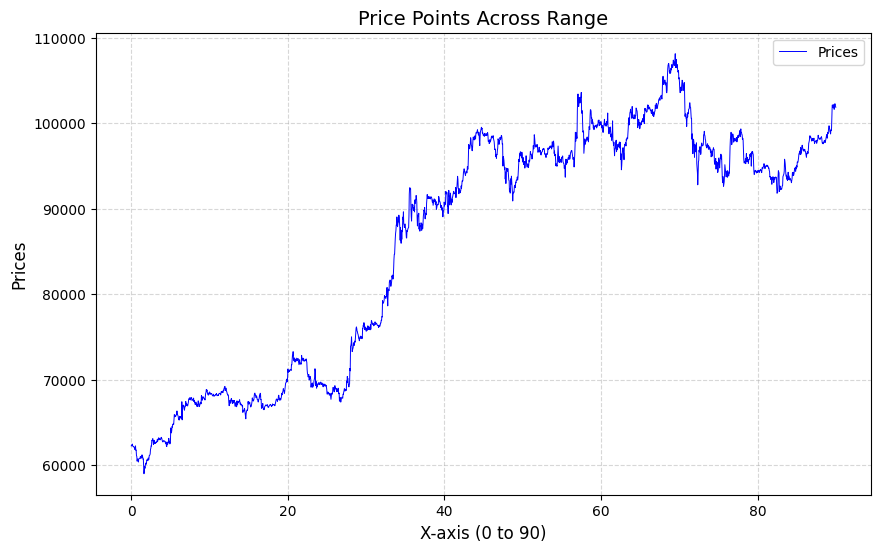

In [57]:
# Generate x values from 0 to 90, evenly spaced for 2160 points
x_values = np.linspace(0, 90, 2160)

# Plot the prices
plt.figure(figsize=(10, 6))
plt.plot(x_values, prices, label="Prices", color="blue", linewidth=0.7)

# Add labels, title, and grid
plt.title("Bitcoin Price over 90 days", fontsize=14)
plt.xlabel("Days (0 - 90)", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Show the plot
plt.show()


Preprocessing the Data

In [62]:
def DataPreprocessing(prices, sequence_length = 30):

        #Use MinMax Scaler to feature scale the prices
                # This is a type of transformation used to shift and rescale values so that each value is on a scale between 0-1
                        # Useful for when you have different features with different scales and you want to make sure all have a similar range of numbers

        scaler = MinMaxScaler()

        #.reshape(-1, 1), you transform a 1D array of shape (length of prices,) into a 2D array of shape (length of prices, 1), turning it into a column vector
                # This is often useful when you're working with machine learning models or other algorithms that expect input in the form of 2D arrays or matrices.

        prices = np.array(prices).reshape(-1, 1)
        print("Prices after reshaping: ")
        print(prices)

        #Apply the Scaler to the data

        scaled_prices = scaler.fit_transform(prices)
        print("Prices after tranforming: ")
        print(scaled_prices)

        #To train the LSTM Model we use sequences of prices so that it can predict a target for that sequence
                #We are going to use every 30 prices to predict the 31st price in the sequence of prices

        sequences = []
        targets = []

        for i in range(len(scaled_prices) - sequence_length):
                sequences.append(scaled_prices[i:i + sequence_length])  #Uses list indexting to select the prices from [0, 29] with [30] as the target up until [prices_length - 30, prices_length] with [price_length] as the target
                targets.append(scaled_prices[i + sequence_length])
        
        #convert to numpy array and return
        return np.array(sequences), np.array(targets), scaler

In [66]:
bit_seq, bit_targ, bit_scaler = DataPreprocessing(prices)
print(bit_seq.shape[2])

Prices after reshaping: 
[[ 62272.6586801 ]
 [ 62334.1887143 ]
 [ 62307.40612118]
 ...
 [102245.0501354 ]
 [102015.3271748 ]
 [101869.41331445]]
Prices after tranforming: 
[[0.06624277]
 [0.06749553]
 [0.06695024]
 ...
 [0.88008588]
 [0.87540869]
 [0.87243787]]
1


Build and Train LSTM Model

In [ ]:
#Long Short-Term Memory Models
    # Type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data
    # Unlike traditional RNNs, LSTMs are equipped with a special architecture that includes memory cells and gates (input gate, forget gate, and output gate) to control the flow of information
    # This helps them remember information over longer periods and avoid the vanishing gradient problem.

def LSTM_Model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    return model

2160

In [ ]:
#Artificial Nueral Network Model
    # Can be used for time series prediction Strengths: Capable of capturing complex patterns and non-linear relationships.
    # More control over number of layers, number of neurons, and activation functions

def ANN_Model(input_shape):
    ann = keras.models.Sequential()
    #input layer
    ann.add(keras.layers.Flatten(input_shape=input_shape))
    #hidden layers
    ann.add(keras.layers.Dense(50, activation='relu'))
                        # ann.add(keras.layers.Dense(128, activation='relu'))
                        # ann.add(keras.layers.Dense(64, activation='relu'))
    #output layer
    ann.add(keras.layers.Dense(1))

    ann.summary()
    ann.compile(optimizer='adam', loss='mse')

    return ann